In [54]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [55]:
import numpy as np
import pandas as pd

In [56]:
import datetime as dt

# Part 1 - Prepare SQLAlchemy 

In [57]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine

In [58]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [59]:
# Preview the data model in Db Browser or a similar tool
# (do this to get a sense as to how the database is structured)
measurement_df = pd.read_sql('SELECT * FROM measurement', conn)
measurement_df.head()



,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [60]:

Hawaii_station_df = pd.read_sql('SELECT * FROM station', conn)
Hawaii_station_df.head()


,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Part 2 - Exploratory Climate Analysis

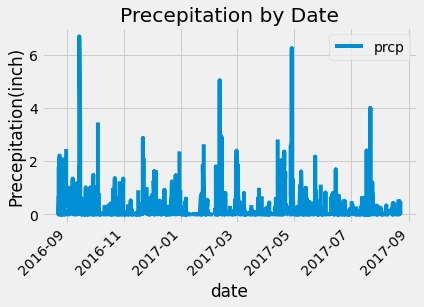

In [75]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the date and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date


query= f'''
    SELECT 
        date, 
        prcp
    FROM 
        measurement
    WHERE
        date >= (SELECT DATE (max (date), "-1 year") FROM measurement)
    ORDER BY date DESC
'''


precipitation_df = pd.read_sql(query, conn)
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])

precipitation_df.set_index('date', inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=45)
plt.title('Precepitation by Date')
plt.ylabel('Precepitation(inch)')
plt.savefig('precepitation.png')
plt.show()


In [76]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [78]:
# Design a query to show how many stations are available in this dataset?
pd.read_sql('SELECT COUNT ( * ) AS "Stations Count" FROM station', conn)



,Stations Count
0,9


In [97]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

query = f'''
    SELECT 
        s.station AS "Station code",
        s.name AS "Station Name",
        COUNT(*) as "Station Count"
    FROM
        measurement m
        INNER JOIN station s
        ON m.station = s.station
    GROUP BY
        s.station,
        s.name
    ORDER BY
        "Station Count" DESC


'''
active_station_df = pd.read_sql(query, conn)
active_station_df.head()

,Station code,Station Name,Station Count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612


In [112]:
top_active_station

'USC00519281'

In [111]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

top_active_station = active_station_df['Station code'].values[0]
top_active_station

query = f'''

    SELECT 
        MAX(tobs),
        min(tobs),
        AVG(tobs)
     FROM
        measurement 
    WHERE 
       'Station code' = '{top_active_station}'


'''
top_active_station_df = pd.read_sql(query, conn)
top_active_station_df

,MAX(tobs),min(tobs),AVG(tobs)
0,None,None,None


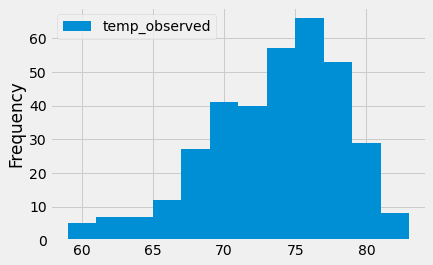

In [113]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


query = f'''
    SELECT
        date,
        tobs AS temp_observed
    FROM
        measurement
    WHERE
        date >= (SELECT DATE(MAX(date),'-1 year') FROM measurement)
        AND station = '{top_active_station}'
    '''
temp_obs_df = pd.read_sql(query, conn)
temp_obs_df

temp_obs_df.plot.hist(bins=12)



## Part 3 - Data Analysis Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    # your code here
    
    return # your code here

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A DataFrame containing the daily normals, tmin, tavg, and tmax
    
    """
    
    # your code here
    
    return # your code here
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
